In [5]:
R.Version()
options(warn = -1)

$platform
[1] "x86_64-w64-mingw32"

$arch
[1] "x86_64"

$os
[1] "mingw32"

$system
[1] "x86_64, mingw32"

$status
[1] ""

$major
[1] "3"

$minor
[1] "5.2"

$year
[1] "2018"

$month
[1] "12"

$day
[1] "20"

$`svn rev`
[1] "75870"

$language
[1] "R"

$version.string
[1] "R version 3.5.2 (2018-12-20)"

$nickname
[1] "Eggshell Igloo"

In [6]:
##load library

library(Seurat)
library(dplyr)
library(ggplot2)
library(sctransform)
library(ComplexHeatmap)
library(circlize)
library("hdf5r")

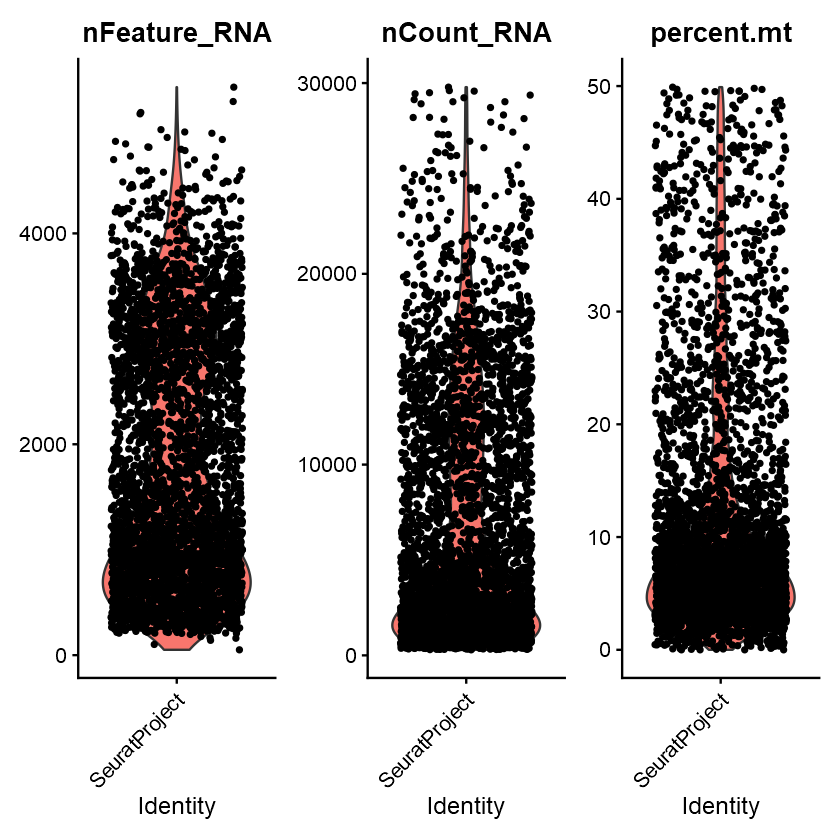

In [7]:
##for Tumor samples
##Following the instruction of cellranger 3.0 https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/aggregate; #--normalize=mapped (default)
##We merge the two process_data Tumor_PBS(Tumor_PBS_molecule_info.h5) and Tumor_D-CAN(Tumor_D-CAN_molecule_info.h5)##
##We then use the merged h5 file ("Merged_Tumor_filtered_feature_bc_matrix.h5") as the import 
Tumor_merged_path <- ("C:\\work in uth\\collaboration\\for CGC\\3.Kolonin_4.10.2020\\sc_data\\updated_mouse_only\\2.merged_1\\2.Tumor\\outs\\filtered_feature_bc_matrix.h5")
Tumor_merged_data <- Read10X_h5(Tumor_merged_path)
##Create Seurat Object
Tumor_merged <- CreateSeuratObject(counts = Tumor_merged_data,min.cells=1)
##setoutput directory
#setwd("YOUR_WORK_DIRECTORY")
#Tumor_merged[["percent.mt"]] <- PercentageFeatureSet(object = Tumor_merged, pattern = "^mt-")
#VlnPlot(object = Tumor_merged, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
##only keep mitochondrial <= 50, nCount_RNA <= 30000,  nFeature_RNA > 0  )
#set random seed as previouly used# Forget 
Tumor_merged <- CreateSeuratObject(counts = Tumor_merged_data,min.cells=1)
Tumor_merged[["percent.mt"]] <- PercentageFeatureSet(object = Tumor_merged, pattern = "^mt-")
Tumor_merged_filtered <- subset(x = Tumor_merged, subset = percent.mt <= 50 & nCount_RNA <= 30000 & nFeature_RNA > 0)
VlnPlot(object = Tumor_merged_filtered, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
##label the cells, due to the merged order "-1" is "PBS" and "-2" is "D-CAN"
label_sim <- rep("PBS", length(Tumor_merged_filtered$orig.ident))
label_sim[grep("-2",names(Tumor_merged_filtered$orig.ident))] <- "DCAN"
Tumor_merged_filtered$sample.indent <- label_sim
set.seed(1) ##Forget to set orginal seed in the manuscript. Thus the shape might be sightly different
Tumor_merged_filtered <- SCTransform(object = Tumor_merged_filtered,verbose = FALSE)
Tumor_merged_filtered <- RunPCA(object = Tumor_merged_filtered,ndims.print = 1:20, nfeatures.print = 10,verbose=FALSE)

In [8]:
##Calculate distance between cells and clustering with a resolution of 0.6
Tumor_merged_filtered <- FindNeighbors(object = Tumor_merged_filtered, dims = 1:20, verbose = FALSE)
Tumor_merged_filtered <- FindClusters(object = Tumor_merged_filtered, verbose = FALSE, resolution = 0.6 )
#Run UMAP
Tumor_merged_filtered <- RunUMAP(object = Tumor_merged_filtered, dims = 1:20, min.dist = 0.75,reduction.name = "UMAP")
##Figure 2B find DEGs between clusters
Idents(object = Tumor_merged_filtered)<- Tumor_merged_filtered$SCT_snn_res.0.6

02:38:52 UMAP embedding parameters a = 0.2734 b = 1.622

02:38:52 Read 3904 rows and found 20 numeric columns

02:38:52 Using Annoy for neighbor search, n_neighbors = 30

02:38:52 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

02:38:53 Writing NN index file to temp file C:\Users\ydai2\AppData\Local\Temp\RtmpqE6KvU\file84ec210b2d81

02:38:53 Searching Annoy index using 1 thread, search_k = 3000

02:38:54 Annoy recall = 100%

02:38:54 Commencing smooth kNN distance calibration using 1 thread

02:38:54 Initializing from normalized Laplacian + noise

02:38:55 Commencing optimization for 500 epochs, with 156128 positive edges

02:39:05 Optimization finished



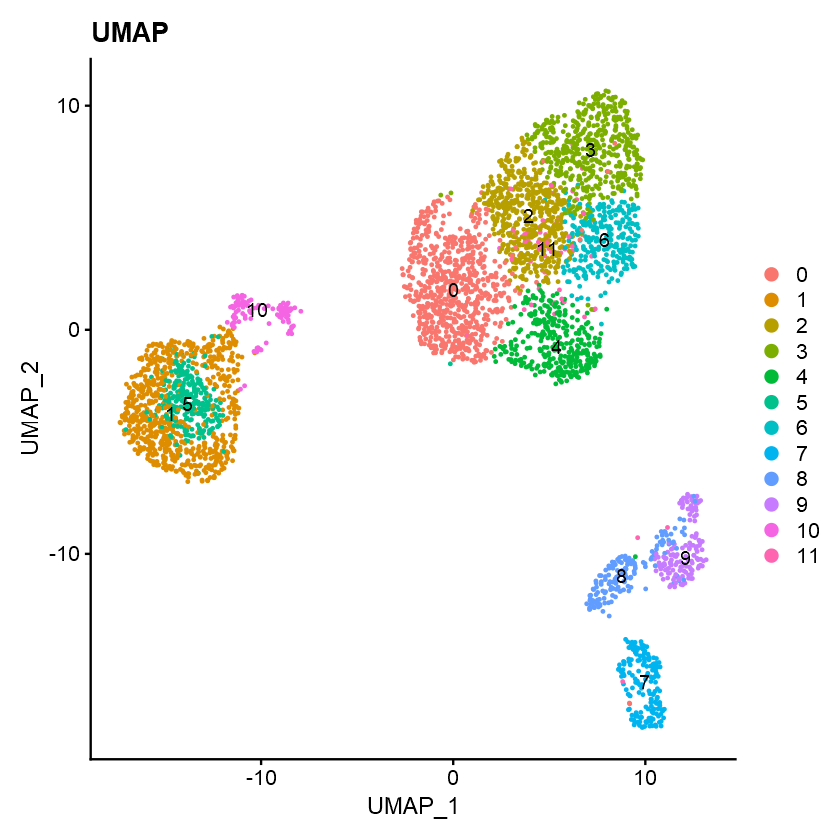

In [9]:
#Figure C
DimPlot(object = Tumor_merged_filtered, label = TRUE,reduction = "UMAP", pt.size = 0.3) + ggtitle(label = "UMAP")

Calculating cluster Cancer cells

Calculating cluster Immune

Calculating cluster Stromal/EC



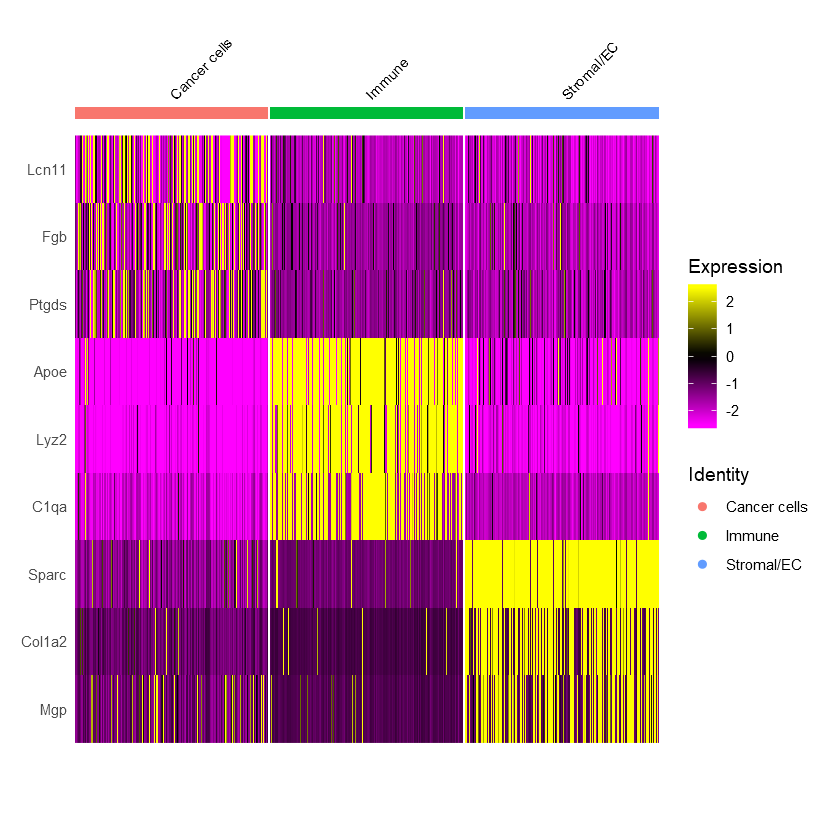

In [10]:
Tumor_merged_filtered <- RenameIdents(object = Tumor_merged_filtered,`0` = "Cancer cells",`1` = "Immune",`2` = "Cancer cells", `3`="Cancer cells",`4`="Cancer cells",	 `5` = "Immune", `6` = "Cancer cells", `7` = "Stromal/EC", 
`8`="Stromal/EC",`9`= "Stromal/EC",`10`= "Immune",`11`="Cancer cells")
Tumor_merged_filtered$renames <- Tumor_merged_filtered@active.ident
##get cluster markers
Tumor_merged_filtered.markers <- FindAllMarkers(object = Tumor_merged_filtered, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
Tumor_merged_filtered.markers %>% group_by(cluster) %>% top_n(n = 3, wt = avg_logFC) -> DEG_matrix
DEG_matrix <- data.frame(DEG_matrix)
##reorder the matrix##
DEG_matrix <- DEG_matrix[order(DEG_matrix[,6],DEG_matrix[,2],decreasing =T),]
DEG_matrix <- DEG_matrix[order(DEG_matrix[,6]),]
heatmap_matrix <- GetAssayData(object = Tumor_merged_filtered, slot = "counts")
##unique gene##
all_markers_need <- unique(DEG_matrix[,7])
DoHeatmap(subset(Tumor_merged_filtered, downsample = 200),features = all_markers_need, size = 3)
